In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")





In [35]:
# load 
train_datasets_log_scal = pd.read_csv('./[no_up]train_datasets(log_scal).csv')
                             
                                      
# Label 만들기
train_target_log_scal = train_datasets_log_scal["TARGET"]
train_target_log_scal = train_target_log_scal.astype("int32")

# TARGET feature 삭제
train_datasets_log_scal.drop(columns="TARGET", inplace=True)


train_datasets_log_scal.rename(columns = {"승인/거부(prev_app)": "Approve_reject_prev_app", "(추정)이자율":"estimated_interest_rate",
                             "연체일": "overdue_date",
                            "연체횟수":"number_of_overdue", "승인액/요청액":"Approval_amount_request_amount",
                            "과거_상환액/총액":"Past_Payment_Amount_Total", "연체기간(pos_cash)":"Overdue_period_pos_cash)",
                            "소액연체비중(pos_cash)":"Share_of_small_delinquency_pos_cash",
                            '거주지일치여부':'Residence_match', '주변인채무':'Neighbors_Debt', 'CB문의':'CB_inquiry',
                            '서류여부':'Whether_documents'}, inplace=True)

import re
train_datasets_log_scal = train_datasets_log_scal.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))




X_train , X_test , y_train , y_test = \
    train_test_split(train_datasets_log_scal, 
                     train_target_log_scal, 
                     test_size=0.2, 
                     random_state=2021,
                     stratify=train_target_log_scal
                    )

In [36]:
train_target_log_scal.shape, train_datasets_log_scal.shape

((303844,), (303844, 144))

In [37]:
train_target_log_scal.value_counts()

0    279379
1     24465
Name: TARGET, dtype: int64

In [38]:
train_datasets_log_scal.value_counts

<bound method DataFrame.value_counts of         Unnamed0  SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
0              0      100002                   0             0   
1              1      100003                   0             0   
2              2      100004                   1             1   
3              3      100006                   0             0   
4              4      100007                   0             0   
...          ...         ...                 ...           ...   
303839    303839      456251                   0             0   
303840    303840      456252                   0             0   
303841    303841      456253                   0             0   
303842    303842      456254                   0             0   
303843    303843      456255                   0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1           0.0          0.476878   -0.178593   
1                     0  

In [39]:
X_train.info(60)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243075 entries, 290095 to 118764
Data columns (total 144 columns):
 #    Column                                 Dtype  
---   ------                                 -----  
 0    Unnamed0                               int64  
 1    SK_ID_CURR                             int64  
 2    NAME_CONTRACT_TYPE                     int64  
 3    FLAG_OWN_CAR                           int64  
 4    FLAG_OWN_REALTY                        int64  
 5    CNT_CHILDREN                           float64
 6    AMT_INCOME_TOTAL                       float64
 7    AMT_CREDIT                             float64
 8    AMT_ANNUITY                            float64
 9    AMT_GOODS_PRICE                        float64
 10   NAME_EDUCATION_TYPE                    int64  
 11   REGION_POPULATION_RELATIVE             float64
 12   DAYS_BIRTH                             float64
 13   DAYS_EMPLOYED                          float64
 14   DAYS_REGISTRATION            

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60769 entries, 248585 to 116003
Columns: 144 entries, Unnamed0 to ORGANIZATION_TYPE_XNA
dtypes: float64(36), int64(108)
memory usage: 67.2 MB


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [45]:
# 앞에서 사용한 것 그대로 복사해서 사용

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [47]:
# LigtGMB
from lightgbm import LGBMClassifier
print(X_train.shape, X_test.shape)

(243075, 144) (60769, 144)


## LGBMClassifier(n_estimators=400)
오차 행렬
[[55764   112]
 [ 4748   145]]
 
정확도: 0.9200, 정밀도: 0.5642, 재현율: 0.0296,    F1: 0.0563, \
AUC:0.7651


In [48]:
lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
wrapper_preds = lgbm_wrapper.predict(X_test)
wrapper_pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.275059
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.271329
[3]	valid_0's binary_logloss: 0.268405
[4]	valid_0's binary_logloss: 0.266092
[5]	valid_0's binary_logloss: 0.263857
[6]	valid_0's binary_logloss: 0.262169
[7]	valid_0's binary_logloss: 0.260605
[8]	valid_0's binary_logloss: 0.259192
[9]	valid_0's binary_logloss: 0.258072
[10]	valid_0's binary_logloss: 0.257003
[11]	valid_0's binary_logloss: 0.25609
[12]	valid_0's binary_logloss: 0.255208
[13]	valid_0's binary_logloss: 0.254442
[14]	valid_0's binary_logloss: 0.253829
[15]	valid_0's binary_logloss: 0.253168
[16]	valid_0's binary_logloss: 0.252612
[17]	valid_0's binary_logloss: 0.25209
[18]	valid_0's binary_logloss: 0.251585
[19]	valid_0's binary_logloss: 0.251157
[20]	valid_0's binary_logloss: 0.250772
[21]	valid_0's binary_logloss: 0.250378
[22]	valid_0's binary_logloss: 0.250041
[23]	valid_0's binary_logloss: 0.24974
[24]	valid_0's binary_logloss:

In [49]:
get_clf_eval(y_test, wrapper_preds, wrapper_pred_proba)

오차 행렬
[[55770   106]
 [ 4773   120]]
정확도: 0.9197, 정밀도: 0.5310, 재현율: 0.0245,    F1: 0.0469, AUC:0.7645


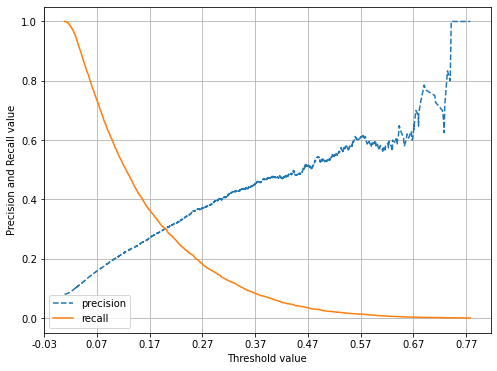

In [50]:
precision_recall_curve_plot(y_test, lgbm_wrapper.predict_proba(X_test)[:, 1])


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

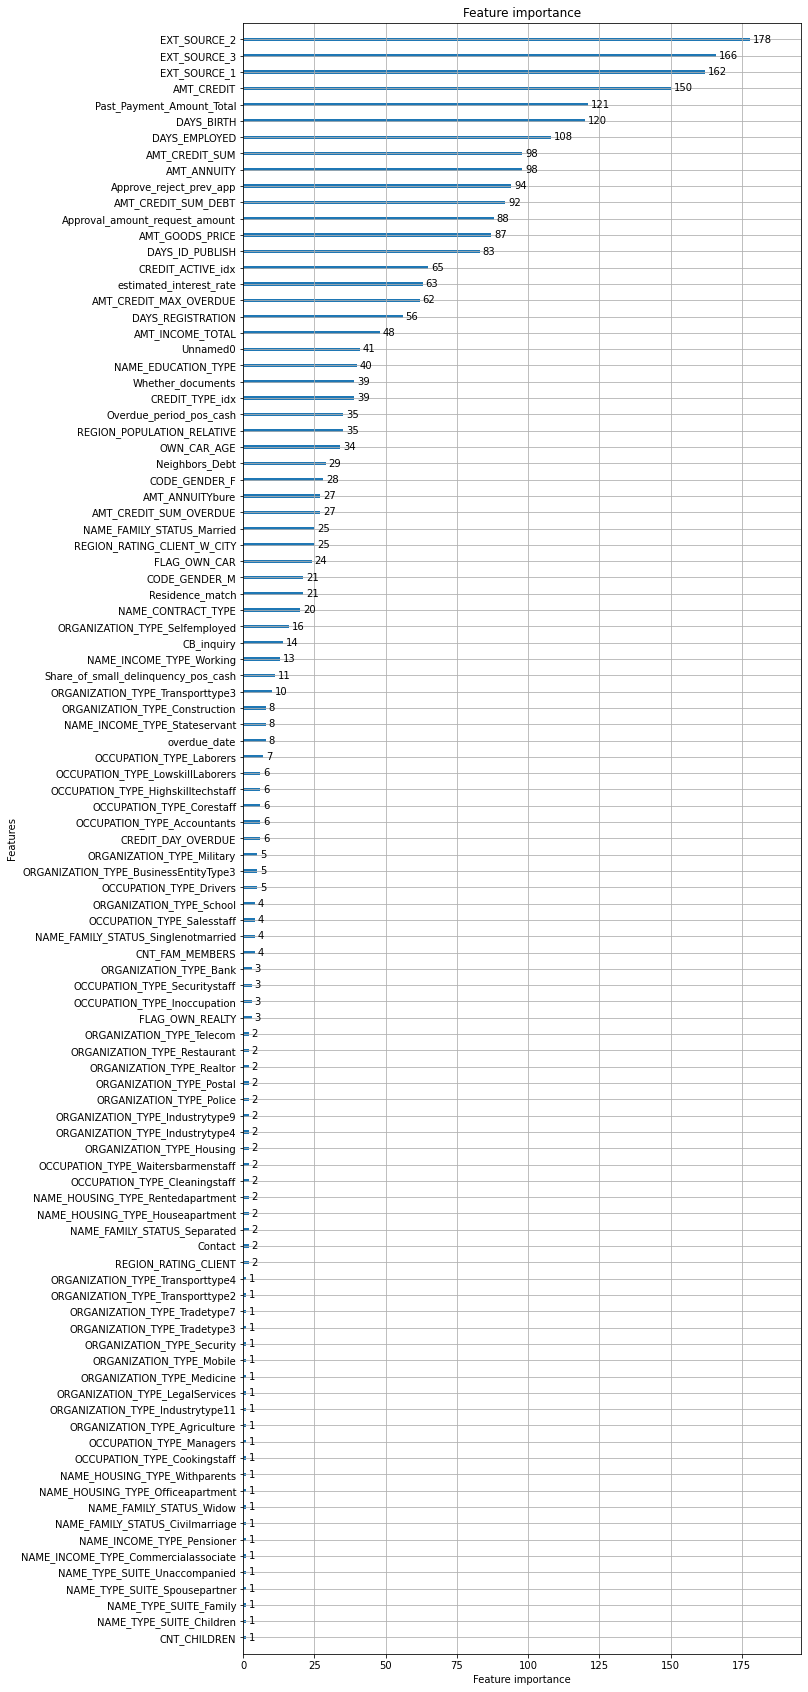

In [51]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(lgbm_wrapper, ax=ax)

## LGBMClassifier(n_estimators=1000)
오차 행렬
[[55769   107]
 [ 4750   143]]
정확도: 0.9201, 정밀도: 0.5720, 재현율: 0.0292,    F1: 0.0556, \
AUC:0.7652

In [52]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

# ROC AUC:0.7652


[1]	valid_0's auc: 0.705199	valid_0's binary_logloss: 0.275059
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.713897	valid_0's binary_logloss: 0.271329
[3]	valid_0's auc: 0.717787	valid_0's binary_logloss: 0.268405
[4]	valid_0's auc: 0.719448	valid_0's binary_logloss: 0.266092
[5]	valid_0's auc: 0.723778	valid_0's binary_logloss: 0.263857
[6]	valid_0's auc: 0.727067	valid_0's binary_logloss: 0.262169
[7]	valid_0's auc: 0.728958	valid_0's binary_logloss: 0.260605
[8]	valid_0's auc: 0.730955	valid_0's binary_logloss: 0.259192
[9]	valid_0's auc: 0.732607	valid_0's binary_logloss: 0.258072
[10]	valid_0's auc: 0.734324	valid_0's binary_logloss: 0.257003
[11]	valid_0's auc: 0.735764	valid_0's binary_logloss: 0.25609
[12]	valid_0's auc: 0.73773	valid_0's binary_logloss: 0.255208
[13]	valid_0's auc: 0.739222	valid_0's binary_logloss: 0.254442
[14]	valid_0's auc: 0.740214	valid_0's binary_logloss: 0.253829
[15]	valid_0's auc: 0.741413	valid_0's binary_logloss

In [53]:
preds = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[55770   106]
 [ 4773   120]]
정확도: 0.9197, 정밀도: 0.5310, 재현율: 0.0245,    F1: 0.0469, AUC:0.7645


In [54]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 수행속도 향상을 위한다면 estimator 수치 조정
lgbm_clf = LGBMClassifier(n_estimators=100)

params = {'num_leaves' :[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

# cv는 5로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=5)
gridcv.fit(X_train, y_train,eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 :', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test[:,1], average='macro'))
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.706946	valid_0's binary_logloss: 0.274981	valid_1's auc: 0.704452	valid_1's binary_logloss: 0.275033
[2]	valid_0's auc: 0.716808	valid_0's binary_logloss: 0.27107	valid_1's auc: 0.712794	valid_1's binary_logloss: 0.271289
[3]	valid_0's auc: 0.722395	valid_0's binary_logloss: 0.268022	valid_1's auc: 0.718407	valid_1's binary_logloss: 0.26835
[4]	valid_0's auc: 0.726803	valid_0's binary_logloss: 0.265416	valid_1's auc: 0.722686	valid_1's binary_logloss: 0.265806
[5]	valid_0's auc: 0.730116	valid_0's binary_logloss: 0.263308	valid_1's auc: 0.726202	valid_1's binary_logloss: 0.263771
[6]	valid_0's auc: 0.731904	valid_0's binary_logloss: 0.261482	valid_1's auc: 0.727822	valid_1's binary_logloss: 0.262051
[7]	valid_0's auc: 0.734531	valid_0's binary_logloss: 0.259768	valid_1's auc: 0.730347	valid_1's binary_logloss: 0.260431
[8]	valid_0's auc: 0.73636	valid_0's binary_logloss: 0.258354	valid_1's auc: 0.73197	valid_1's binary_logloss: 0.259135
[9]	valid_0's auc: 0.738191	

TypeError: '(slice(None, None, None), 1)' is an invalid key

In [55]:
print('GridSearchCV 최적 파라미터 :', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

GridSearchCV 최적 파라미터 : {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC:0.7661


In [57]:
#
lgbm_clf_hyper_1 = LGBMClassifier(n_estimators=4000, min_child_samples=100,
                                  max_depth = 128, 
                                  num_leaves=32,
                                  subsample=0.8)

evals = [(X_test, y_test)]
lgbm_clf_hyper_1.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf_hyper_1.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.705612	valid_0's binary_logloss: 0.275036
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.713783	valid_0's binary_logloss: 0.27133
[3]	valid_0's auc: 0.718055	valid_0's binary_logloss: 0.268378
[4]	valid_0's auc: 0.720122	valid_0's binary_logloss: 0.265982
[5]	valid_0's auc: 0.724482	valid_0's binary_logloss: 0.263749
[6]	valid_0's auc: 0.727756	valid_0's binary_logloss: 0.26205
[7]	valid_0's auc: 0.730142	valid_0's binary_logloss: 0.260397
[8]	valid_0's auc: 0.73167	valid_0's binary_logloss: 0.259147
[9]	valid_0's auc: 0.733446	valid_0's binary_logloss: 0.257938
[10]	valid_0's auc: 0.73494	valid_0's binary_logloss: 0.25693
[11]	valid_0's auc: 0.736885	valid_0's binary_logloss: 0.255945
[12]	valid_0's auc: 0.738215	valid_0's binary_logloss: 0.255168
[13]	valid_0's auc: 0.738948	valid_0's binary_logloss: 0.254484
[14]	valid_0's auc: 0.740163	valid_0's binary_logloss: 0.253769
[15]	valid_0's auc: 0.741139	valid_0's binary_logloss: 0

In [58]:
preds_hyper_1 = lgbm_clf_hyper_1.predict(X_test)
pred_proba_hyper_1 = lgbm_clf_hyper_1.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, preds_hyper_1, pred_proba_hyper_1)

오차 행렬
[[55726   150]
 [ 4744   149]]
정확도: 0.9195, 정밀도: 0.4983, 재현율: 0.0305,    F1: 0.0574, AUC:0.7668


## LOG_SCAL_LGBMClassifier(파라미터값 지정)
오차 행렬
[[55735   141]
 [ 4716   177]]
정확도: 0.9201, 정밀도: 0.5566, 재현율: 0.0362,    F1: 0.0679, \
#### AUC:0.7705


In [59]:
#
lgbm_clf = LGBMClassifier(n_estimators=4000,
                learning_rate=0.01,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

# ROC AUC:0.0.7705

[1]	valid_0's auc: 0.689316	valid_0's binary_logloss: 0.279599
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.723901	valid_0's binary_logloss: 0.279056
[3]	valid_0's auc: 0.728967	valid_0's binary_logloss: 0.278524
[4]	valid_0's auc: 0.728063	valid_0's binary_logloss: 0.278123
[5]	valid_0's auc: 0.730994	valid_0's binary_logloss: 0.277623
[6]	valid_0's auc: 0.735841	valid_0's binary_logloss: 0.277358
[7]	valid_0's auc: 0.740192	valid_0's binary_logloss: 0.27699
[8]	valid_0's auc: 0.739826	valid_0's binary_logloss: 0.276531
[9]	valid_0's auc: 0.742587	valid_0's binary_logloss: 0.276316
[10]	valid_0's auc: 0.742411	valid_0's binary_logloss: 0.275866
[11]	valid_0's auc: 0.741647	valid_0's binary_logloss: 0.275413
[12]	valid_0's auc: 0.742782	valid_0's binary_logloss: 0.275079
[13]	valid_0's auc: 0.741983	valid_0's binary_logloss: 0.274641
[14]	valid_0's auc: 0.74109	valid_0's binary_logloss: 0.274246
[15]	valid_0's auc: 0.741165	valid_0's binary_logloss

In [60]:
preds = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[55735   141]
 [ 4716   177]]
정확도: 0.9201, 정밀도: 0.5566, 재현율: 0.0362,    F1: 0.0679, AUC:0.7705


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

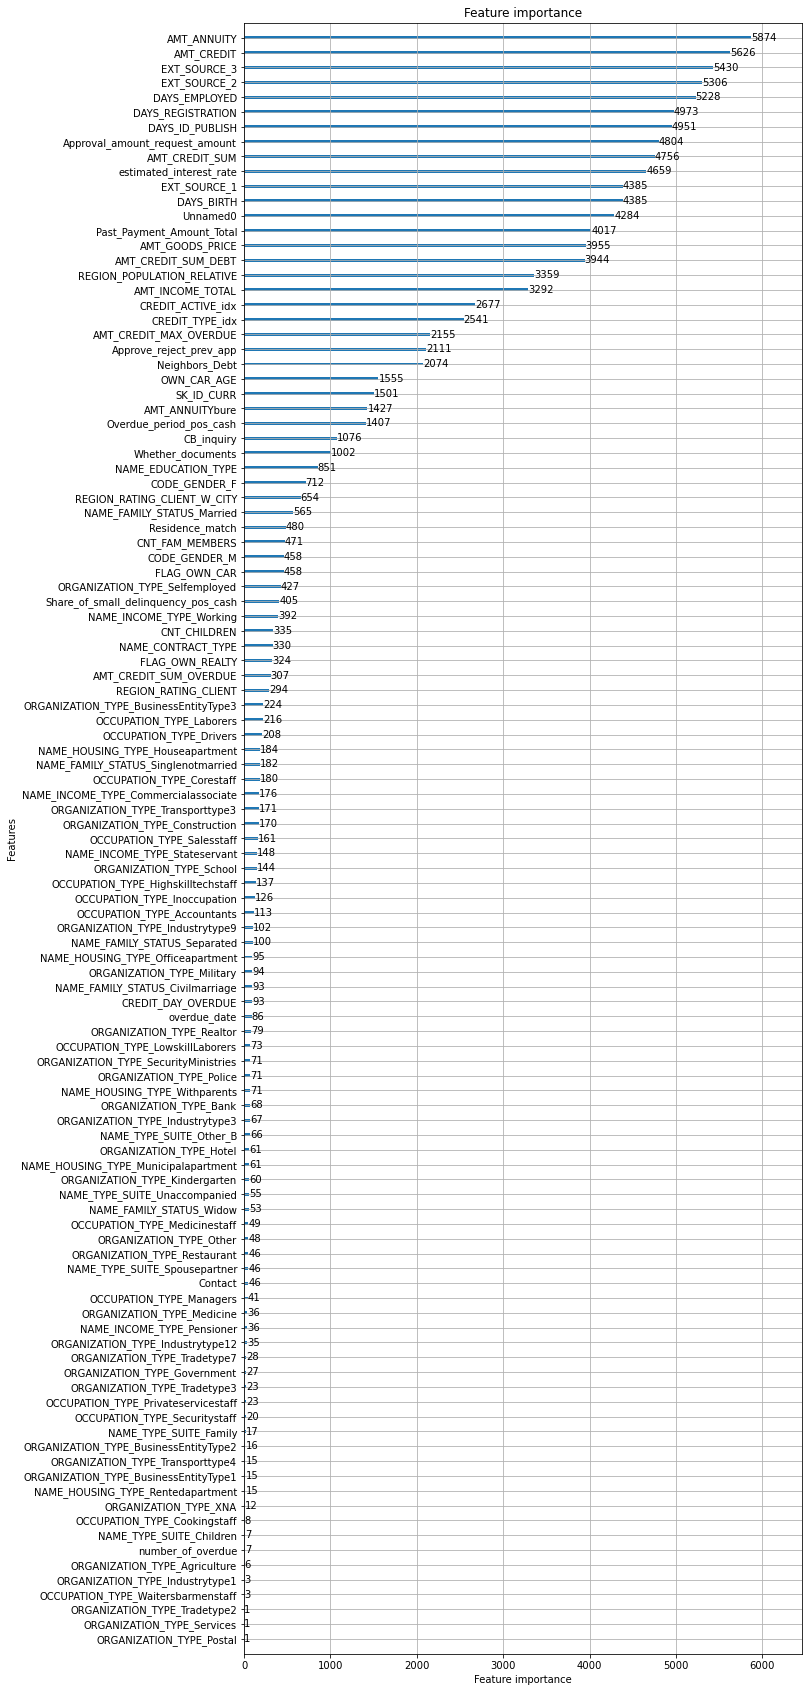

In [61]:
fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(lgbm_clf, ax=ax)

## LGBMRegressor

In [62]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('최적 평균 RMSE 값:', np.round(rmse, 4))
    print('최적 파라미터:', grid_model.best_params_)
    
    return grid_model.best_estimator_

In [63]:
from lightgbm import LGBMRegressor

# lgbm_params 값을 바꾸어주며 learning_rate, max_depth 등 파라미터 성능 비교 시도했었음.
lgbm_params = {'n_estimators':[3300]}

lgbm_reg = LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fractio

In [64]:
best_lgbm

LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, reg_lambda=5, subsample=0.7)

In [65]:
lgbm_params

{'n_estimators': [3300]}

In [66]:
evals = [(X_test, y_test)]
best_lgbm.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.695774	valid_0's l2: 0.0734237
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.704724	valid_0's l2: 0.0729108
[3]	valid_0's auc: 0.707038	valid_0's l2: 0.0724673
[4]	valid_0's auc: 0.71754	valid_0's l2: 0.0721017
[5]	valid_0's auc: 0.720202	valid_0's l2: 0.0717345
[6]	valid_0's auc: 0.721969	valid_0's l2: 0.071429
[7]	valid_0's auc: 0.724017	valid_0's l2: 0.0711518
[8]	valid_0's auc: 0.72517	valid_0's l2: 0.0708995
[9]	valid_0's auc: 0.726422	valid_0's l2: 0.0707152
[10]	valid_0's auc: 0.727118	valid_0's l2: 0.0705353
[11]	valid_0's auc: 0.727742	valid_0's l2: 0.0703959
[12]	valid_0's auc: 0.728998	valid_0's l2: 0.0702711
[13]	valid_0's auc: 0.731209	valid_0's l2: 0.0701429
[14]	valid_0's auc: 0.732872	valid_0's l2: 0.0700449
[15]	valid_0's auc: 0.733504	valid_0's l2: 0.0699236
[16]	valid_0's auc: 0.734515	valid_0's l2: 0.0698394
[17]	valid_0's auc: 0.735905	valid_0's l2: 0.0697552
[18]	valid_0's auc: 0.736847	valid_0's l2: 0.0696

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

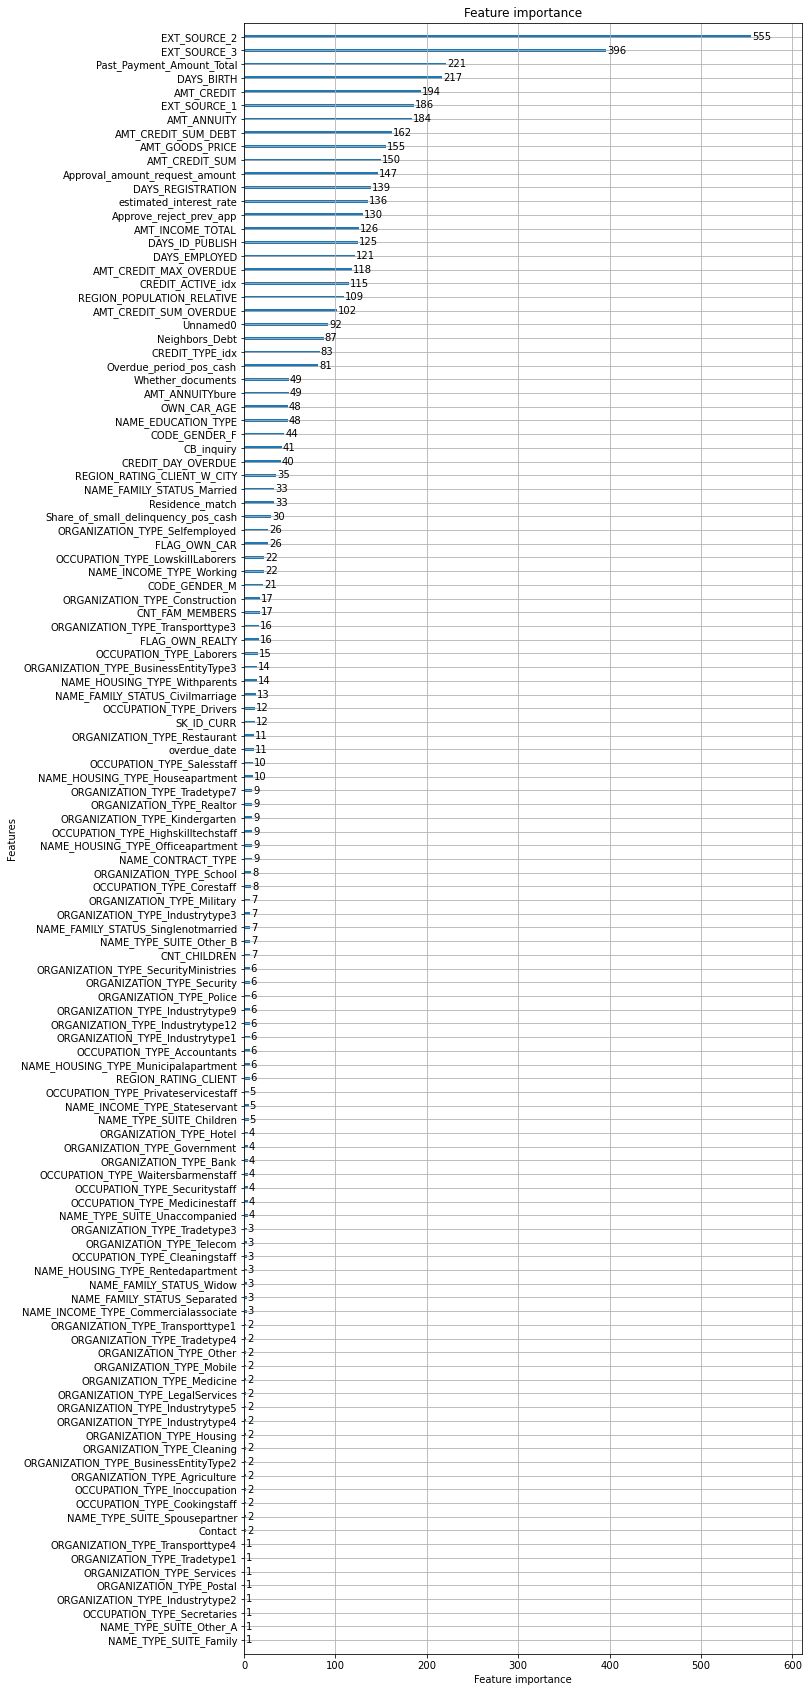

In [67]:
fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(best_lgbm, ax=ax)

In [68]:
#
lgbm_clf_reg = LGBMClassifier(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, reg_lambda=5, subsample=0.7)

evals = [(X_test, y_test)]
lgbm_clf_reg.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score_reg = roc_auc_score(y_test, lgbm_clf_reg.predict_proba(X_test)[:, 1], average='macro')

print('ROC AUC:{0:.4f}'.format(lgbm_roc_score_reg))

# ROC AUC:

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's auc: 0.695774	valid_0's binary_logloss: 0.275939
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.704477	valid_0's binary_logloss: 0.272759
[3]	valid_0's auc: 0.713075	valid_0's binary_logloss: 0.269799
[4]	valid_0's auc: 0.720892	valid_0's binary_logloss: 0.267988
[5]	valid_0's auc: 0.721872	valid_0's binary_logloss: 0.265947
[6]	valid_0's auc: 0.722226	valid_0's binary_logloss: 0.264388
[7]	valid_0's auc: 0.723371	valid_0's binary_logloss: 0.262901
[8]	valid_0's auc: 0.725454	valid_0's binary_logloss: 0.261578
[9]	valid_0's auc: 0.726669	valid_0's binary_logloss: 0.260531
[10]	valid_0's auc: 0.727615	valid_0's binary_logloss: 0.259585
[11]	valid_0's auc: 0.729088	valid_0's binary_logloss: 0.258661
[1

## SMOTE 적용

In [69]:
# 앞으로 피처 엔지니어링을 수행할 때마다
# 모델을 학습/예측/평가하는데 사용할 함수 작성

# 사이킷런의 Estimater객체, 학습/테스트 데이터 세트 입력 받아서
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgr_train=None, tgt_test=None):
    model.fit(ftr_train, tgr_train) # 학습
    pred = model.predict(ftr_test) # 예측(값)
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 예측 확률
    get_clf_eval(tgt_test, pred, pred_proba)  # 실제 데이터, 예측값, 예측 확률

In [70]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[55735   141]
 [ 4716   177]]
정확도: 0.9201, 정밀도: 0.5566, 재현율: 0.0362,    F1: 0.0679, AUC:0.7705


In [71]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=64, n_jobs=-1, \
                         boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

오차 행렬
[[55743   133]
 [ 4755   138]]
정확도: 0.9196, 정밀도: 0.5092, 재현율: 0.0282,    F1: 0.0534, AUC:0.7649


In [72]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgr_train=None, tgt_test=None):
    model.fit(ftr_train, tgr_train) # 학습
    pred = model.predict(ftr_test) # 예측(값)
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 예측 확률
    get_clf_eval(tgt_test, pred, pred_proba)  # 실제 데이터, 예측값, 예측 확률

In [73]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

# train 데이터 셋으로 들어오는 값들에 대해서 오버 샘플링
# 타깃값의 분포에 맞춰 피처값 생성
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [74]:
print('SMOT 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOT 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)



# 결과
# 적용 후 train 데이터가 많이 늘어남
# 적용 후 레이블 값 두개가 동일 : (증식 되었음)

SMOT 적용 전 학습용 피처/레이블 데이터 세트 :  (243075, 144) (243075,)
SMOT 적용 후 학습용 피처/레이블 데이터 세트 :  (447006, 144) (447006,)


In [75]:
y_train_over.value_counts()


0    223503
1    223503
Name: TARGET, dtype: int64

In [76]:
# LightGBM 모델 적용
lgbm_clf_over = LGBMClassifier(n_estimators=4000, num_leaves=64, n_jobs=-1, boost_from_average=False)

get_model_train_eval(lgbm_clf_over, ftr_train=X_train_over, ftr_test=X_test, tgr_train=y_train_over, tgt_test=y_test)

# 결과


오차 행렬
[[55659   217]
 [ 4668   225]]
정확도: 0.9196, 정밀도: 0.5090, 재현율: 0.0460,    F1: 0.0843, AUC:0.7350
